In [1]:
import numpy as np
from skimage.feature import hog
from skimage import exposure
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.io import imread
import nibabel as nib
import matplotlib.pyplot as plt


In [2]:
# Load MRI heart image from NIfTI file
# Replace 'your_image.nii.gz' with the path to your NIfTI file
# For simplicity, we'll use a placeholder image here
nifti_file_path = 'F:\Image CHD\ImageCHD_dataset\Training Data\ct_1002_image.nii.gz'
nifti_img = nib.load(nifti_file_path)
image = nifti_img.get_fdata()

In [3]:
# Preprocess the image as needed (e.g., resizing, denoising, normalization)
# Here's a basic preprocessing example (you might need more advanced preprocessing depending on your data)
# Example: Resize the image to a desired size
from skimage.transform import resize
image = resize(image, (256, 256, image.shape[-1]), anti_aliasing=True)  # Ensure the same spatial dimensions for all channels


In [4]:
# Compute HOG features for each channel separately
# Specify HOG parameters
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)
hog_features_per_channel = []
hog_images_per_channel = []
for channel in range(image.shape[-1]):
    # Calculate HOG features for the current channel
    hog_features, hog_image = hog(image[..., channel], orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, visualize=True)
    hog_features_per_channel.append(hog_features)
    hog_images_per_channel.append(hog_image)

In [5]:
# Concatenate HOG features from all channels
hog_features = np.concatenate(hog_features_per_channel)


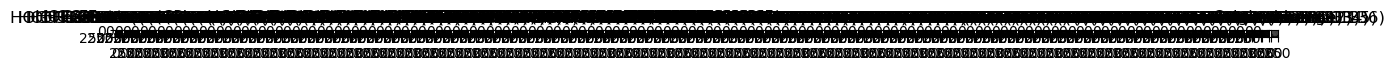

In [6]:
# Plot the original image and its corresponding HOG representation for each channel
fig, axes = plt.subplots(nrows=1, ncols=len(hog_images_per_channel) + 1, figsize=(15, 5))

for ax, hog_image, channel_idx in zip(axes, hog_images_per_channel + [None], range(len(hog_images_per_channel) + 1)):
    if channel_idx < len(hog_images_per_channel):
        ax.imshow(hog_image, cmap=plt.cm.gray)
        ax.set_title(f'HOG Features (Channel {channel_idx})')
    else:
        ax.imshow(image[..., 0], cmap=plt.cm.gray)  # Show the first channel as the original image
        ax.set_title('Original Image')

plt.show()

In [7]:

# Calculate texture properties using GLCM
properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
distances = [1]  # distance between pixels
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # angles for pixel pairs


In [8]:
# Convert the image to unsigned integer type
image_uint = (image[..., 0] * 255).astype(np.uint8)

# Calculate GLCM matrix
glcm = graycomatrix(image_uint, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)


In [9]:
# Calculate texture properties
texture_props = dict()
for prop in properties:
    texture_props[prop] = graycoprops(glcm, prop).ravel()[0]  # Assuming one distance and angle for simplicity


In [10]:
# Print texture properties
print("Texture Properties:")
for prop, value in texture_props.items():
    print(f"{prop}: {value}")

Texture Properties:
contrast: 10945.405775127929
dissimilarity: 85.40065870103025
homogeneity: 0.011818155649790945
energy: 0.0048009296944910755
correlation: 0.0012226790527432273


In [11]:
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops
import nibabel as nib
import pandas as pd

In [12]:
# Folder containing the NIfTI files
folder_path = 'F:\Image CHD\ImageCHD_dataset\Training Data'

In [13]:

# Function to calculate texture properties using GLCM for a given image
def calculate_texture_properties(image):
    # Calculate texture properties using GLCM
    properties = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    distances = [1]  # distance between pixels
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # angles for pixel pairs

    # Convert the image to unsigned integer type
    image_uint = (image[..., 0] * 255).astype(np.uint8)

    # Calculate GLCM matrix
    glcm = graycomatrix(image_uint, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

    # Calculate texture properties
    texture_props = dict()
    for prop in properties:
        texture_props[prop] = graycoprops(glcm, prop).ravel()[0]  # Assuming one distance and angle for simplicity

    return texture_props


In [14]:
# List to store the results
results = []

In [15]:
# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.nii.gz'):
        # Load MRI heart image from NIfTI file
        file_path = os.path.join(folder_path, file_name)
        nifti_img = nib.load(file_path)
        image = nifti_img.get_fdata()

        # Calculate texture properties using GLCM
        texture_props = calculate_texture_properties(image)

        # Append the results with file name
        result_entry = {'File': file_name}
        result_entry.update(texture_props)
        results.append(result_entry)


In [16]:
# Create a DataFrame from the results
df = pd.DataFrame(results)

In [17]:
# Save the DataFrame to an Excel file
excel_file_path = 'HOG_properties.xlsx'
df.to_excel(excel_file_path, index=False)

print(f"Texture properties saved to {excel_file_path}")

Texture properties saved to HOG_properties.xlsx


In [1]:
import os
import numpy as np
from skimage.feature import hog
from skimage import exposure
import nibabel as nib
import pandas as pd


In [2]:
# Function to calculate HOG properties for a given 2D slice
def calculate_hog_properties(slice_image):
    # Specify HOG parameters
    orientations = 9
    pixels_per_cell = (8, 8)  # Adjust the cell size according to your data
    cells_per_block = (2, 2)   # Adjust the block size according to your data
    
    # Calculate HOG features
    hog_features, _ = hog(slice_image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block, visualize=True)
    
    # Compute properties from HOG features
    contrast = np.mean(hog_features)
    dissimilarity = np.std(hog_features)
    homogeneity = np.median(hog_features)
    energy = np.sum(np.square(hog_features)) / hog_features.size
    
    # Check if hog_features is a scalar
    if np.isscalar(hog_features):
        correlation = np.nan  # Assign NaN if hog_features is a scalar
    else:
        # Check if hog_features has at least 2 elements before calculating correlation
        if hog_features.ndim >= 2 and hog_features.shape[0] > 1:
            correlation = np.corrcoef(hog_features)[0, 1]  # Calculate correlation
        else:
            correlation = np.nan  # Assign NaN if insufficient data
    
    return {'contrast': contrast, 'dissimilarity': dissimilarity, 
            'homogeneity': homogeneity, 'energy': energy, 'correlation': correlation}

In [3]:
# Folder containing the NIfTI files
folder_path = 'F:\Image CHD\ImageCHD_dataset\Training Data'


In [4]:
# List to store the results
results = []

In [5]:
# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.nii.gz'):
        # Load MRI heart image from NIfTI file
        file_path = os.path.join(folder_path, file_name)
        nifti_img = nib.load(file_path)
        image = nifti_img.get_fdata()

        # Calculate HOG properties for each slice
        hog_props_per_slice = []
        for slice_idx in range(image.shape[2]):
            slice_image = image[..., slice_idx]
            hog_props = calculate_hog_properties(slice_image)
            hog_props_per_slice.append(hog_props)
        
        # Average HOG properties across slices
        avg_hog_props = {prop: np.mean([hog_props[prop] for hog_props in hog_props_per_slice])
                         for prop in hog_props_per_slice[0].keys()}
        
        # Append the results with file name
        result_entry = {'File': file_name}
        result_entry.update(avg_hog_props)
        results.append(result_entry)


In [ ]:
# Create a DataFrame from the results
df = pd.DataFrame(results)

# Save the DataFrame to an Excel file
excel_file_path = 'hog_propertie.xlsx'
df.to_excel(excel_file_path, index=False)

print(f"HOG properties saved to {excel_file_path}")